In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using StaticArrays
using Printf

  Activating environment at `C:\Users\hilld\Documents\git\ocrl\ocrl_quadruped_mpc\Project.toml`


## Dynamics

In [197]:
function skew_symmetric(r::Vector) #function to convert vector to cross-product skew-symmetric matrix
    R = [0 -r[3] r[2]; r[3] 0 -r[1]; -r[2] r[1] 0]
    return R
end

function R_z(sigma::Real)
     R = [cos(sigma) sin(sigma) 0; -sin(sigma) cos(sigma) 0; 0 0 1]
    return R
end

#dynamics function of quadruped
function dynamics(model::NamedTuple, x::Vector, u::Vector, r1::Vector, r2::Vector, r3::Vector, r4::Vector)
    #state is defined as [x,theta,x_dot,theta_dot]^T
    #force is defined as [fl,fr,bl,br]^T where each one is composed of x,y,z forces
    
    m, J = model.m, model.J

    A = vcat(hcat(zeros(6,6), vcat(hcat(R_z(x[6]),zeros(3,3)),hcat(zeros(3,3),Matrix{Float64}(I,3,3)))), zeros(6,12)) #A matrix
    #B1 is first 9 rows of B matrix, first 6 rows are zeros, next rows are F = ma
    B1 = vcat(zeros(6,12), 1/m * hcat(hcat(Matrix{Float64}(I,3,3),Matrix{Float64}(I,3,3)),hcat(Matrix{Float64}(I,3,3),Matrix{Float64}(I,3,3))))
    #B2 is last 3 rows of B matrix effecting theta_dot, these are tau = J*theta_dot
    B2 = hcat(hcat(J \ skew_symmetric(r1 - x[1:3]), J \ skew_symmetric(r2 - x[1:3])),hcat(J \ skew_symmetric(r3 - x[1:3]), J \ skew_symmetric(r4 - x[1:3])))
    B = vcat(B1,B2) #add B1 to B2 to get full B matrix
    C = vcat(vcat(zeros(8),1),zeros(3)) #gravity term    
    
    Ag = vcat(hcat(A,C),zeros(1,13))
    Bg = vcat(B,zeros(1,12))
    
    x_dot = Ag * x + Bg * u #calculate x_dot (full state derivative)
    
#     @show Ag
#     @show Ag * x
#     @show Bg
#     @show Bg * u
    
    return x_dot
end

#rk4 function for discritization of dynamics
function rk4(model::NamedTuple, ode::Function, x::Vector, u::Vector, r1::Vector, r2::Vector, r3::Vector, r4::Vector, dt::Real)::Vector
    k1 = dt * ode(model, x,        u, r1, r2, r3, r4)
    k2 = dt * ode(model, x + k1/2, u, r1, r2, r3, r4)
    k3 = dt * ode(model, x + k2/2, u, r1, r2, r3, r4)
    k4 = dt * ode(model, x + k3,   u, r1, r2, r3, r4)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end


rk4 (generic function with 1 method)

## Reference Trajectory and Gait Planner

In [338]:
function reference_trajectory(model, xic, xg, dt, gait_period, num_gaits)
    # creates a reference Xref and Uref for walker
    
    l, w, m, g = model.l, model.w, model.m, model.g
    
    N = Int(num_gaits * gait_period / dt + 2) #define N
    
    half_gait = Int(gait_period / (2 * dt))     #number of time steps in half a gait period
    quarter_gait = Int(gait_period / (4 * dt))  #number of time steps in a quarter of a gait period
    
    fl_s = zeros(N) #initialize fl_s etc. These are the gait timings
    fl_s[1] = 1
    fl_s[N] = 1
    fr_s = zeros(N)
    fr_s[1] = 1
    fr_s[N] = 1
    bl_s = zeros(N)
    bl_s[1] = 1    
    bl_s[N] = 1
    br_s = zeros(N)
    br_s[1] = 1
    br_s[N] = 1
    
    #diagonal trot gait
#     state = 0
#     for i = 2:half_gait:N-1  #every quarter gait, switch feet
#         if(state == 0)
#             fl_s[i:i+half_gait-1] = zeros(half_gait)
#             fr_s[i:i+half_gait-1] = ones(half_gait)
#             bl_s[i:i+half_gait-1] = ones(half_gait)
#             br_s[i:i+half_gait-1] = zeros(half_gait)
#             state = 1
#         elseif(state == 1)
#             fl_s[i:i+half_gait-1] = ones(half_gait)
#             fr_s[i:i+half_gait-1] = zeros(half_gait)
#             bl_s[i:i+half_gait-1] = zeros(half_gait)
#             br_s[i:i+half_gait-1] = ones(half_gait)
#             state = 0
#         end
#     end
    
    #bear walk gait
    state = 0
    for i = 2:quarter_gait:N-1  #every quarter gait, switch feet
        if(state == 0)
            fl_s[i:i+quarter_gait-1] = zeros(quarter_gait)
            fr_s[i:i+quarter_gait-1] = ones(quarter_gait)
            bl_s[i:i+quarter_gait-1] = ones(quarter_gait)
            br_s[i:i+quarter_gait-1] = ones(quarter_gait)
            state = 1
        elseif(state == 1)
            fl_s[i:i+quarter_gait-1] = ones(quarter_gait)
            fr_s[i:i+quarter_gait-1] = ones(quarter_gait)
            bl_s[i:i+quarter_gait-1] = ones(quarter_gait)
            br_s[i:i+quarter_gait-1] = zeros(quarter_gait)
            state = 2
        elseif(state == 2)
            fl_s[i:i+quarter_gait-1] = ones(quarter_gait)
            fr_s[i:i+quarter_gait-1] = zeros(quarter_gait)
            bl_s[i:i+quarter_gait-1] = ones(quarter_gait)
            br_s[i:i+quarter_gait-1] = ones(quarter_gait)
            state = 3
        elseif(state == 3)
            fl_s[i:i+quarter_gait-1] = ones(quarter_gait)
            fr_s[i:i+quarter_gait-1] = ones(quarter_gait)
            bl_s[i:i+quarter_gait-1] = zeros(quarter_gait)
            br_s[i:i+quarter_gait-1] = ones(quarter_gait)
            state = 0
        end
    end
    
#     @show fl_s
#     @show fr_s
#     @show bl_s
#     @show br_s
    
    Xref = [zeros(13) for i = 1:N] #initialize state reference trajectory
    
    v = (xg[3] - xic[3]) / ((N-1) * dt) #assuming straight line path, get constant velocity required
    
    for i = 1:N #fill in state reference trajectory
        Xref[i] = vcat(((N-i) * xic[1:6] + (i-1) * xg[1:6]) / (N-1), [v,0,0,0,0,0,g])
    end
    
#     Uref = [zeros(12) for i = 1:N-1] #initialize state reference trajectory
    
#     for i = 1:N-1
#         count = fl_s[i] + fr_s[i] + bl_s[i] + br_s[i]
#         Uref[i][3] = fl_s[i] * -m*g / count
#         Uref[i][6] = fr_s[i] * -m*g / count
#         Uref[i][9] = bl_s[i] * -m*g / count
#         Uref[i][12] = br_s[i] * -m*g / count
#     end
    
    r1 = [zeros(3) for i=1:N] #initialize r vectors
    r2 = [zeros(3) for i=1:N]
    r3 = [zeros(3) for i=1:N]
    r4 = [zeros(3) for i=1:N]
    
    r1[1] = [l/2 + Xref[1][1], w/2 + Xref[1][2], 0] #start standing up straight
    r2[1] = [l/2 + Xref[1][1], -w/2 + Xref[1][2], 0]
    r3[1] = [-l/2 + Xref[1][1], w/2 + Xref[1][2], 0]
    r4[1] = [-l/2 + Xref[1][1], -w/2 + Xref[1][2], 0]
    
    r1[N] = [l/2 + Xref[N][1], w/2 + Xref[N][2], 0] #end standing up straight
    r2[N] = [l/2 + Xref[N][1], -w/2 + Xref[N][2], 0]
    r3[N] = [-l/2 + Xref[N][1], w/2 + Xref[N][2], 0]
    r4[N] = [-l/2 + Xref[N][1], -w/2 + Xref[N][2], 0]
    
    for i = 2:N-1 #for each sequential half gait, set legs reaching past shoulders to start
        r1[i] = r1[i-1]
        r2[i] = r2[i-1]
        r3[i] = r3[i-1]
        r4[i] = r4[i-1]
        if((fl_s[i-1] == 0) & (fl_s[i] == 1))
            r1[i] = [l/2 + Xref[i][1] + gait_period/2 * v, w/2 + Xref[i][2], 0]
        end
        if((fr_s[i-1] == 0) & (fr_s[i] == 1))
            r2[i] = [l/2 + Xref[i][1] + gait_period/2 * v, -w/2 + Xref[i][2], 0]
        end
        if((bl_s[i-1] == 0) & (bl_s[i] == 1))
            r3[i] = [-l/2 + Xref[i][1] + gait_period/2 * v, w/2 + Xref[i][2], 0]
        end
        if((br_s[i-1] == 0) & (br_s[i] == 1))
            r4[i] = [-l/2 + Xref[i][1] + gait_period/2 * v, -w/2 + Xref[i][2], 0]
        end
    end
        
    return Xref, N, fl_s, fr_s, bl_s, br_s, r1, r2, r3, r4
end

reference_trajectory (generic function with 1 method)

## Test Dynamics and Gait Planner

xg = [0.8, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Xref[1] = [0.0, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -9.81]
Uref[1] = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
fl_s[1] = 1.0
fr_s[1] = 1.0
bl_s[1] = 1.0
br_s[1] = 1.0
r1[1] = [0.5, 0.2, 0.0]
r2[1] = [0.5, -0.2, 0.0]
r3[1] = [-0.5, 0.2, 0.0]
r4[1] = [-0.5, -0.2, 0.0]
x_dot = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -9.81, 0.0, 0.0, 0.0, 0.0]


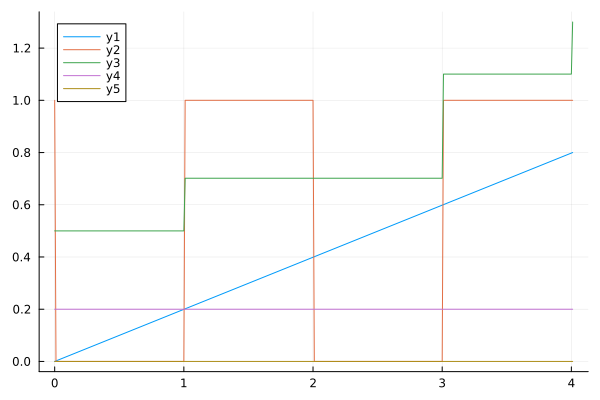

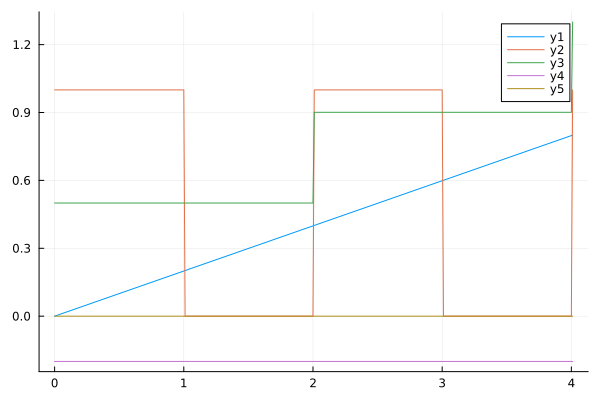

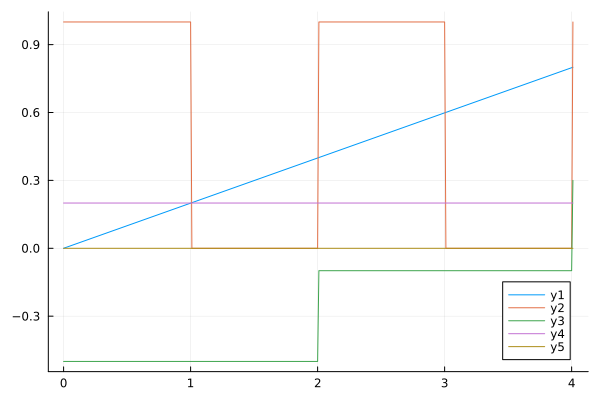

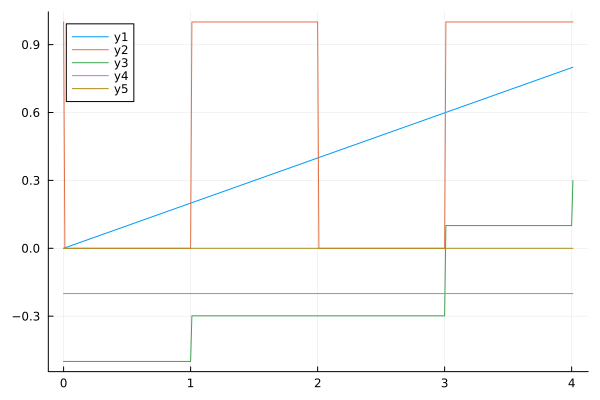

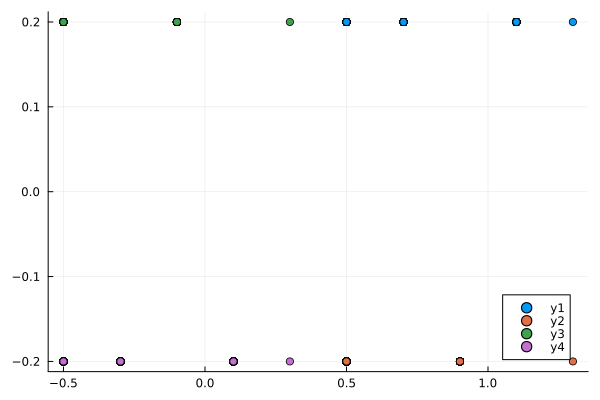

In [340]:
#model defined here
model = (g = -9.81, m = 5.0, J = diagm([1,5.2,5.8]), l = 1.0, w = 0.4, h = 0.6, mu = 0.5)
v = 0.2
dt = 0.01
gait_period = 2
num_gaits = 2
xic = [0,0,model.h,0,0,0,0,0,0,0,0,0]
xg = [v*gait_period*num_gaits,0,model.h,0,0,0,0,0,0,0,0,0]
@show xg

tf = N * dt 
t_vec = 0:dt:tf

#construct reference trajectory
Xref, N, fl_s, fr_s, bl_s, br_s, r1, r2, r3, r4 = reference_trajectory(model, xic, xg, dt, gait_period, num_gaits)

# Uref = [zeros(12) for i=1:N-1]

@show Xref[1]
@show Uref[1]
@show fl_s[1]
@show fr_s[1]
@show bl_s[1]
@show br_s[1]
@show r1[1]
@show r2[1]
@show r3[1]
@show r4[1]

x_dot = dynamics(model, Xref[1], Uref[1], r1[1], r2[1], r3[1], r4[1])

@show x_dot

# # calculate Jacobians
# As = [zeros(nx,nx) for i = 1:N-1]
# Bs = [zeros(nx,nu) for i = 1:N-1]
# for i = 1:N-1
#     As[i] = FD.jacobian(x -> rk4(model, dynamics, x, Uref[i], r1[i], r2[i], r3[i], r4[i], dt), Xref[i])
#     Bs[i] = FD.jacobian(u -> rk4(model, dynamics, Xref[i], u, r1[i], r2[i], r3[i], r4[i], dt), Uref[i])
# end
# #this C is our gravity term (not sure if this is done correctly)
# C = rk4(model, dynamics, zeros(12), zeros(12), r1[1], r2[1], r3[1], r4[1], dt)

# Xsim = [zeros(12) for i = 1:N]
# Xsim[1] = Xref[1]

# for i = 1:N-1
#     Xsim[i+1] = rk4(model, dynamics, Xsim[i], U[i], r1[i], r2[i], r3[i], r4[i], dt)
# end

# Xsim = hcat(Xsim...)

# display(plot(t_vec[1:end-1], Xsim[1:3,:]', lc = [:red :green :blue]))

# display(plot(t_vec[1:end-1], Xsim[4:6,:]', lc = [:red :green :blue]))
# plot(t_vec[1:end-1], fl_s)
# plot!(t_vec[1:end-1], fr_s)
# plot!(t_vec[1:end-1], bl_s)
# display(plot!(t_vec[1:end-1], br_s))
    
r1 = hcat(r1...)
r2 = hcat(r2...)
r3 = hcat(r3...)
r4 = hcat(r4...)
Xref = hcat(Xref...)

plot(t_vec[1:end-1], Xref[1,:])
plot!(t_vec[1:end-1], fl_s)
display(plot!(t_vec[1:end-1], r1[1:3,:]'))

plot(t_vec[1:end-1], Xref[1,:])
plot!(t_vec[1:end-1], fr_s)
display(plot!(t_vec[1:end-1], r2[1:3,:]'))
    
plot(t_vec[1:end-1], Xref[1,:])
plot!(t_vec[1:end-1], bl_s)
display(plot!(t_vec[1:end-1], r3[1:3,:]'))

plot(t_vec[1:end-1], Xref[1,:])
plot!(t_vec[1:end-1], br_s)
display(plot!(t_vec[1:end-1], r4[1:3,:]'))

scatter(r1[1,:], r1[2,:], mode="markers")
scatter!(r2[1,:], r2[2,:], mode="markers")
scatter!(r3[1,:], r3[2,:], mode="markers")
display(scatter!(r4[1,:], r4[2,:], mode="markers"))
    
# plot(t_vec[1:end-2], Urefm[1:3,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls FL")
# display(plot!(t_vec[1:end-2], Um[1:3,:]', lc = [:red :green :blue]))
#     plot(t_vec[1:end-2], Urefm[4:6,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls FR")
# display(plot!(t_vec[1:end-2], Um[4:6,:]', lc = [:red :green :blue]))
# plot(t_vec[1:end-2], Urefm[7:9,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls BL")
# display(plot!(t_vec[1:end-2], Um[7:9,:]', lc = [:red :green :blue]))
# plot(t_vec[1:end-2], Urefm[10:12,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls BR")
# display(plot!(t_vec[1:end-2], Um[10:12,:]', lc = [:red :green :blue]))

## Solve

X[2] = [0.0007817802334177796, -0.00015980215277697262, 0.40150495542327247, -6.44945731050652e-5, -0.00012654211629699945, -3.736562413852027e-8, 0.031271210090613, -0.0063920833540767495, 0.06019821767647311, -0.0012096750588811854, -0.003753040166842376, -1.4946248468143372e-6, -9.80999999997246]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [0.0007817828582225661, -0.00015978933816848526, 0.40150495544187037, -6.44945753819231e-5, -0.0029315673851955104, -3.259595090664259e-5, 0.03127121015780979, -0.0063920831855698, 0.060198217674814015, -0.001209797712544727, -0.11595404620964012, -0.0013038366196956568, -9.81]
As[j] * Xsim[j] + Bs[j] * Usim[j] = [0.0007817802539452449, -0.00015980207963924492, 0.40150495544187037, -6.449457538191244e-5, -0.0029315673851955074, -3.2595950906642214e-5, 0.031271210157809794, -0.006392083185569797, 0.06019821767481409, -0.0012096750629556551, -0.11595405110416267, -0.0013038380362656904, -9.81]
X[2] = [0.00338716525514725

X[2] = [0.034465983597282264, 0.030660256954476953, 0.41829194299098177, -0.00034872065762554897, -0.007312453713729991, -1.990397042925575e-5, 0.602820711600452, 0.015141969112673044, -0.07462125727501678, 0.0016683705890512058, 0.04890077775773342, 0.000199141245839006, -9.809999999882255]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [0.03446631688784541, 0.03064251833874598, 0.41829194300251926, -0.03804975518769982, -0.029134937014837103, 0.0018645951757512863, 0.6028207115932332, 0.015141969091969508, -0.07462125727338367, -1.5069815169287186, -0.7796591854960851, 0.07419401996879058, -9.809999999889186]
As[j] * Xsim[j] + Bs[j] * Usim[j] = [0.03446598356646017, 0.030660256940926434, 0.4182919430025192, -0.00034872065729156103, -0.009784533357096845, 5.8393476994456264e-5, 0.6028207115932332, 0.015141969091969512, -0.07462125727338359, 0.0016683705895507038, -0.04998240780014748, 0.0033310391449046747, -9.809999999889186]
X[2] = [0.06011692702266854, 0.0

As[j] * Xsim[j] + Bs[j] * Usim[j] = [0.11116156407039882, -0.059470144456782004, 0.42122353352893915, 0.0008959573417869931, -0.01599364481033906, 0.0005641031713483733, 0.6038603501866967, -0.14997616574661254, -0.020000991562503345, -0.0005004111719131745, -0.09802716167286682, 0.007163696268346952, -9.809999999859583]
X[2] = [0.14694905608948142, -0.06567913873573045, 0.42106223796233927, 0.0011108583111953416, -0.006036075755444007, 0.00018480584104716517, 0.827639328451712, -0.09838360481328667, 0.013549169520331314, -0.0019621323992936217, 0.27848749545514945, -0.001848056211884408, -9.809999999849339]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [0.14695642781377138, -0.06562414690459159, 0.4210622379646913, 0.0890892997599308, -0.029294594697756703, -0.0048601835724373784, 0.8276393284467967, -0.09838360479263089, 0.013549169521836997, 3.584308731898505, -0.59706950310069, -0.21463798602376705, -9.809999999850236]
As[j] * Xsim[j] + Bs[j] * Usim[j] = 

X[2] = [0.2518354223692407, 0.040014336187424906, 0.41412604018876026, -0.0005274896029736349, -0.007017527239739918, -7.652159939305305e-5, 0.783737011202148, 0.13247344007466308, -0.014361128278464433, 0.0011569784912312056, 0.14430096203053808, 0.0007652190080289352, -9.809999999844543]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [0.2518397988421929, 0.03999030054688729, 0.41412604018971744, -0.051265582991495494, -0.027961270872045085, 0.002249642014062775, 0.7837370111992268, 0.13247344006534678, -0.014361128277666182, -2.1035669972739, -0.637862516418042, 0.10258445079995572, -9.809999999845328]
As[j] * Xsim[j] + Bs[j] * Usim[j] = [0.2518354223628036, 0.0400143361821681, 0.41412604018971744, -0.0005274896028459441, -0.009736906928945323, -0.00024368267533830335, 0.7837370111992268, 0.13247344006534678, -0.014361128277666113, 0.0011569784914543181, 0.03552577450899574, -0.005921224028277451, -9.809999999845328]
X[2] = [0.2837947900994067, 0.04377107682

X[2] = [0.36723554490167853, -0.0327272333324137, 0.41038001402436264, 0.000319356688042443, -0.004456425491232129, 1.976170369962679e-5, 0.6572885058723398, -0.12103875705023115, -0.06718035289512506, -8.384744870097904e-7, 0.07043861778427482, -0.00019761799288935288, -9.809999999862741]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [0.36723804054899845, -0.0327128968590029, 0.4103800140254135, 0.04049420389108347, -0.01926581258768271, -0.00135021620785836, 0.6572885058706832, -0.1210387570462702, -0.06718035289458422, 1.6527164283549687, -0.4636022204738666, -0.05224381478894476, -9.809999999864042]
As[j] * Xsim[j] + Bs[j] * Usim[j] = [0.36723554489710636, -0.03272723333113472, 0.4103800140254136, 0.00031935668799916157, -0.007223673317537441, -0.00013893978909635047, 0.6572885058706832, -0.1210387570462702, -0.06718035289458424, -8.38474580784794e-7, -0.040251295243710794, -0.0065456777054007905, -9.809999999864042]
X[2] = [0.39278635225399655, -0.035966

X[2] = [0.45124560006816683, 0.01701430644146973, 0.4099945505144906, -0.00031423981725725553, -0.005035585572636401, -8.317186210899016e-6, 0.5596758771808079, 0.0768447860489157, -0.08039475814648991, 0.001440909024323848, 0.03784634267273876, 8.31766415162773e-5, -9.809999999856997]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [0.4512459040301367, 0.01701201530481701, 0.40999455051414374, -0.019435448848259932, -0.019445937548240727, 0.0003467250521958541, 0.5596758771790169, 0.07684478603981222, -0.08039475814610578, -0.8099454614407184, -0.506562380706309, 0.02068777172080631, -9.809999999856155]
As[j] * Xsim[j] + Bs[j] * Usim[j] = [0.4512456000694091, 0.017014306429569935, 0.40999455051414374, -0.0003142398170603258, -0.007485546854173802, -0.00021061662664040756, 0.5596758771790169, 0.07684478603981224, -0.0803947581461057, 0.0014409090245374005, -0.060152108576647725, -0.008008800975434438, -9.809999999856155]
X[2] = [0.47917055031051936, 0.021962106

X[2] = [0.5638686766752635, -0.010147590060383717, 0.40697848341593346, 0.00011323951466073163, -0.0035761680144444636, 1.2487314634763098e-6, 0.4678956250274579, -0.07487960324076641, -0.05518529633533236, -0.0004607462918949181, 0.02861295285964176, -1.2490724443977354e-5, -9.809999999859434]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [0.5638688822036918, -0.01014634562432133, 0.4069784834148801, 0.009828255749072751, -0.013319882649321716, -0.00020502260276502576, 0.4678956250261901, -0.07487960323353743, -0.055185296334848435, 0.42554852198534154, -0.33355353530769044, -0.011369732482428476, -9.809999999859624]
As[j] * Xsim[j] + Bs[j] * Usim[j] = [0.5638686766758495, -0.010147590052079374, 0.4069784834148801, 0.0001132395145362631, -0.00598971805851348, 8.696783593988049e-5, 0.4678956250261901, -0.07487960323353743, -0.055185296334848366, -0.000460746292064587, -0.06792904889462137, 0.0034162734535676817, -9.809999999859624]
X[2] = [0.5872212117781425,

As[j] * Xsim[j] + Bs[j] * Usim[j] = [0.6542704451016139, -0.00024063710771300104, 0.40569251523401173, 0.0001119398951223602, -0.005884712134318879, -4.483962977544588e-6, 0.2906841282480799, 0.07765504138470145, -0.014382276873516231, -0.0006104018905664076, -0.09073280645079165, -0.0001797939021497753, -9.80999999986219]
X[2] = [0.6716208692424016, 0.0034540949901456616, 0.4044465601411417, 4.9000211574951256e-5, -0.0027511813832335258, 5.671681261429187e-9, 0.4033328373973372, 0.07013424202133993, -0.03545592687733298, -0.00029514337076636915, 0.02288783605531901, -5.376102476712748e-8, -9.809999999863306]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [0.6716207851409735, 0.003454488788946869, 0.4044465601418328, -0.0013553259207662828, -0.00966237508805663, -4.4925568624070695e-5, 0.40333283739498293, 0.07013424201408551, -0.03545592687692448, -0.08824310206999372, -0.22999991574606407, 6.885907293920075e-5, -9.809999999863722]
As[j] * Xsim[j] + Bs[j] * U

X[2] = [0.7760223535732486, 0.002698293580338591, 0.40270226924283903, -0.00015074072998226426, -0.002306552111707454, 8.953656956940571e-10, 0.36665409504953705, -0.0565413555228764, -0.018135244003144934, 0.0009339751830780896, 0.019463006158224216, -1.010783191088131e-8, -9.809999999856952]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [0.7760220230115439, 0.002696392573169389, 0.40270226924278574, -0.005874581890975048, -0.007681635895841395, 0.00032271011675514085, 0.3666540950491269, -0.05654135552114853, -0.01813524400302669, -0.20210817827861122, -0.1746156336604139, 0.011489085347718676, -9.809999999856851]
As[j] * Xsim[j] + Bs[j] * Usim[j] = [0.7760223535733561, 0.002698293582818631, 0.40270226924278574, -0.0001507407300168888, -0.004727766750201955, 2.9564566693958876e-5, 0.3666540950491269, -0.056541355521148536, -0.018135244003026685, 0.0009339751830373256, -0.07738557937909162, 0.0011825367452026688, -9.809999999856851]
X[2] = [0.793288268942932

X[2] = [0.8643697288966878, -0.008341238387649007, 0.4019306424232266, 0.0002560550471951002, -0.0024234779840170916, -6.334867696205489e-10, 0.24995474562152817, 0.04428915012827329, 0.0014901941877117114, -0.0014030260082582696, 0.00494218726858602, 2.5941513153752605e-8, -9.809999999857189]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [0.8643695607621769, -0.008340308220186289, 0.40193064242293386, 0.012692988427938682, -0.007213906333564484, -0.00023696849410856743, 0.2499547456204608, 0.0442891501231099, 0.0014901941878553244, 0.48073042680976624, -0.17128940763594494, -0.009342597730340012, -9.80999999985718]
As[j] * Xsim[j] + Bs[j] * Usim[j] = [0.8643697288970488, -0.008341238383825878, 0.40193064242293386, 0.0002560550468806884, -0.004893618756089317, 4.0735944197558825e-5, 0.2499547456204608, 0.0442891501231099, 0.0014901941878552871, -0.0014030260081371244, -0.09386344369313915, 0.0016294890497631249, -9.80999999985718]
X[2] = [0.8795763093237912, 

X[2] = [0.9677684125483197, 0.009435727228366171, 0.40116525150951066, -0.0002650086066041072, -0.002044894141077394, 1.4636593382823664e-8, 0.2418308251043166, -0.03561618634347238, 0.005261251304987773, 0.0015435097239757012, 0.004708508438342336, -1.5235850393406878e-7, -9.809999999856728]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [0.9677682807248963, 0.009434824610799664, 0.4011652515093517, -0.01363379327977374, -0.005763303502591251, 0.00023871953635036118, 0.24183082510410514, -0.035616186341884175, 0.005261251305039254, -0.5223995180000484, -0.12901679909480074, 0.009597885527429795, -9.809999999856805]
As[j] * Xsim[j] + Bs[j] * Usim[j] = [0.967768412549152, 0.009435727228981616, 0.4011652515093517, -0.0002650086065942869, -0.004504214882149039, -4.973167351677599e-5, 0.24183082510410514, -0.035616186341884175, 0.005261251305039183, 0.0015435097239395812, -0.09366432120409444, -0.001990004763116929, -9.809999999856805]
X[2] = [0.9830192346703946, 

As[j] * Xsim[j] + Bs[j] * Usim[j] = [1.0603899644343906, -0.009336327537147759, 0.40047259214142467, 0.0002426304333428723, -0.004170358942390024, 9.842929231371726e-5, 0.19068436872652003, 0.021412759858851098, 0.010780745802193459, -0.0016813236999494345, -0.10174030945157055, 0.003938084402352535, -9.809999999856315]
X[2] = [1.0713685877640398, -0.008017771275448206, 0.4008401970846329, 0.00021405255314755183, -0.0015992795501706247, -1.0922320565482532e-8, 0.2484605644703447, 0.03132949053868565, 0.003923451920089205, -0.0015873883068637192, 0.005881359758493673, 1.1071769058813457e-7, -9.809999999856386]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [1.0713684874728007, -0.00801695870245199, 0.4008401970845916, 0.011617739080578034, -0.004356504797443619, -0.00020944699407272291, 0.24846056447026998, 0.03132949053820233, 0.00392345192011195, 0.4455929636468397, -0.08877767349250978, -0.008488671062440566, -9.809999999856345]
As[j] * Xsim[j] + Bs[j] * Usi

X[2] = [1.174513226082637, 0.007499491088015096, 0.40055433530605716, -0.00018230165897178074, -0.0012030857980637089, 5.682088650531332e-9, 0.2575664833277013, -0.029757332770700466, 0.0025579335679694675, 0.0016487541254393769, 0.007331514693768232, -5.834961374547021e-8, -9.809999999858542]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [1.174513130138831, 0.0074986384931767375, 0.40055433530602574, -0.01087924618221055, -0.0031299942607687006, 0.00021187818252068138, 0.2575664833275521, -0.029757332769979862, 0.002557933568014226, -0.4178384179333616, -0.05334268592035409, 0.008609786467891175, -9.809999999858526]
As[j] * Xsim[j] + Bs[j] * Usim[j] = [1.1745132260827575, 0.007499491088599649, 0.40055433530602574, -0.00018230165897663634, -0.0036716114891675138, -4.99156125409091e-5, 0.2575664833275521, -0.029757332769979862, 0.0025579335680143145, 0.001648754125421957, -0.0914095129496054, -0.0019969101348559677, -9.809999999858526]
X[2] = [1.18966162511804

As[j] * Xsim[j] + Bs[j] * Usim[j] = [1.2554323823938385, -0.008932432144047157, 0.3998632770868511, 0.00018931718555963975, -0.0034977782288297646, 9.339575158768666e-5, 0.18121282272370184, 0.004356689748782769, 0.008981327292111652, -0.0015539207696866498, -0.10253115737202685, 0.003735824486394632, -9.8099999998591]
X[2] = [1.265161182849755, -0.008278341888951154, 0.4002625903164299, 0.0001983905829628835, -0.0010393458689917342, 6.056421208796607e-11, 0.20793919551966883, 0.02180692039269952, 0.006991201888081593, -0.0018235045075943536, 0.0010666720389808475, -1.3278783154204383e-9, -9.80999999985899]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [1.265161161652389, -0.008278111601642086, 0.4002625903164408, 0.011547076779790366, -0.002347141049878742, -7.450444457324033e-5, 0.20793919551932577, 0.02180692039172029, 0.006991201888140487, 0.45039881689661976, -0.03618079163328666, -0.0034998732781882052, -9.809999999858984]
As[j] * Xsim[j] + Bs[j] * Usim

X[2] = [1.3669802900931964, 0.008011521355774905, 0.40029188120680825, -0.00018778211876711704, -0.0007780900041807657, -6.708895344975395e-11, 0.2163597658266532, -0.02368687468188976, 0.006076759519632614, 0.0018825211540630916, 0.002334507548144233, 1.7206911846401607e-9, -9.809999999867292]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [1.366980260931679, 0.00801121914651453, 0.40029188120687387, -0.011292974107835987, -0.0015775568965387698, 9.248563745616077e-5, 0.2163597658255104, -0.02368687467869431, 0.006076759519827796, -0.43969534455518217, -0.013895212929008098, 0.004227166203699436, -9.809999999867289]
As[j] * Xsim[j] + Bs[j] * Usim[j] = [1.366980290092561, 0.008011521358142929, 0.40029188120687387, -0.00018778211881291838, -0.003269322209966556, -8.800183872822417e-5, 0.2163597658255104, -0.02368687467869431, 0.00607675951982789, 0.0018825211539856767, -0.09731478067832687, -0.0035200691449175986, -9.809999999867289]
X[2] = [1.379008292389502, 

As[j] * Xsim[j] + Bs[j] * Usim[j] = [1.4576508150201268, -0.009199560507722464, 0.40007087280872167, 0.00019308134343255144, -0.003131108347995709, 8.973592459207609e-5, 0.19453676104797643, 0.007657079610343544, 0.007030063074055959, -0.0016611237725476721, -0.10045528348261971, 0.0035894370357138776, -9.809999999867776]
X[2] = [1.4681949705179174, -0.008438077327427561, 0.4003638149370892, 0.00018570309279104477, -0.0005801622968793787, 1.510153632151007e-11, 0.22722945884687545, 0.02280224753739526, 0.004687622061147201, -0.0018802898828742414, 0.003781308331380185, -4.137053561732662e-11, -9.809999999867804]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [1.4681949275136263, -0.008437592439674423, 0.4003638149370942, 0.01180457896860803, -0.0010314804953551638, -0.00013791932562862827, 0.22722945884667145, 0.02280224753679514, 0.004687622061184989, 0.45969579983822517, 0.0018935655011431832, -0.005976728959170443, -9.809999999867799]
As[j] * Xsim[j] + Bs[j

X[2] = [1.5687645654460824, 0.00880229145571701, 0.4004617632606368, -0.00020805757302031484, -0.0004414710571277942, -2.446442333400808e-12, 0.22308586810851014, -0.025180820346614053, 0.003533383311827308, 0.002054682256461448, 0.003246721816528541, 5.249945051226632e-11, -9.809999999867857]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [1.5687645298061865, 0.00880193076767942, 0.40046176326064337, -0.012343430290269287, -0.0006115690405860947, 0.00010663342687526058, 0.22308586810839334, -0.025180820346296724, 0.003533383311845276, -0.48069967229800575, 0.013030313687648454, 0.004876512117558645, -9.809999999867859]
As[j] * Xsim[j] + Bs[j] * Usim[j] = [1.5687645654460185, 0.008802291455965573, 0.4004617632606434, -0.00020805757302512913, -0.0029235402805688664, -9.516520074679595e-5, 0.22308586810839331, -0.025180820346296727, 0.0035333833118453284, 0.0020546822564535593, -0.09603604712060274, -0.003806607879515839, -9.809999999867859]
X[2] = [1.5804089766

X[2] = [1.6687612387094444, -0.009716585498806916, 0.4005228993983256, 0.00023618842439761324, -0.0003722814745878811, 5.964174531462195e-13, 0.21926228024146727, 0.024463500306677446, 0.002660548154468817, -0.0021586988386506963, 0.0027358795509657362, -5.891696719832846e-11, -9.809999999868099]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [1.668761210935817, -0.009716299030260203, 0.400522899398339, 0.01348688516845219, -0.0004003386349681461, -8.839259765886094e-5, 0.21926228024129193, 0.024463500306224163, 0.0026605481544956554, 0.526550283346132, 0.01842042989305639, -0.004255120053463125, -9.809999999868092]
As[j] * Xsim[j] + Bs[j] * Usim[j] = [1.6687612387093496, -0.00971658549924223, 0.400522899398339, 0.00023618842440693215, -0.002853715746120688, 0.00010753455434577702, 0.21926228024129193, 0.02446350030622416, 0.0026605481544957343, -0.0021586988386397992, -0.09652149130959241, 0.004301382091058113, -9.809999999868092]
X[2] = [1.680209517734866, -

X[2] = [1.7579622365663066, 0.011083949546656433, 0.40037356815180963, -0.00023492359068496253, -0.00040293988094222737, 3.155013010053063e-13, 0.2010438676789835, 0.0009872580874081183, 0.004939598953968858, 0.0015903153862785982, 0.0004669678753462653, -1.1390168515226246e-11, -9.809999999868282]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [1.7579622413987346, 0.011083709900354748, 0.40037356815181113, -0.014235440533472563, -0.0003706595495667331, 7.99986116150654e-5, 0.20104386767891158, 0.0009872580875901794, 0.004939598953981316, -0.5665029994133665, 0.017353602679408022, 0.003808577941576808, -9.809999999868275]
As[j] * Xsim[j] + Bs[j] * Usim[j] = [1.7579622365662848, 0.01108394954679241, 0.40037356815181113, -0.0002349235906878706, -0.0028956907824470974, -9.001772878020707e-5, 0.20104386767891158, 0.0009872580875901794, 0.004939598953981383, 0.0015903153862738169, -0.09924306818462605, -0.0036007091752178083, -9.809999999868275]
X[2] = [1.768398727

X[2] = [1.8621032908264417, -0.013133694926638722, 0.40124705924374704, 0.00020627481906911017, 0.00012511794994349377, 2.593401452462435e-12, 0.2793061873957073, -0.035491014991814354, 0.0022003524245866562, 0.00016864516973129665, 0.010265252657017342, 1.2169037150691904e-10, -9.80999999986833]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [1.8621035059629256, -0.013132085980627295, 0.40124705924374676, 0.015344840645609158, 0.0007213149609964224, -0.0003690486062056894, 0.279306187395652, -0.03549101499196691, 0.0022003524245929563, 0.620588702360134, 0.05206249229193405, -0.015117223751497334, -9.809999999868326]
As[j] * Xsim[j] + Bs[j] * Usim[j] = [1.8621032908264117, -0.013133694926761254, 0.40124705924374676, 0.00020627481907158088, -0.002335511171936443, -1.049094933341876e-6, 0.279306187395652, -0.03549101499196691, 0.0022003524245929884, 0.00016864516973582195, -0.08815991221795381, -4.196377938912058e-5, -9.809999999868326]
X[2] = [1.87913237008553

X[2] = [1.948364620711194, 0.016423866966563568, 0.4342884477945542, -0.00033853872353952814, -0.0018629368347750064, 0.0006411498312441454, 0.1123021317346214, 0.1304062986977749, 0.3348456171471999, -0.0008324840114608111, 0.00526780786536615, -0.006518107536958648, -9.809999999871895]
rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt) = [1.948370745093441, 0.016419504742466423, 0.43428844779407016, -0.017902803161316063, -0.0009707731381839962, 0.0008542571509214817, 0.11230213172281339, 0.13040629872899306, 0.334845617148547, -0.7714417443358081, 0.04692268558538003, 0.002873358200320409, -9.809999999870874]
As[j] * Xsim[j] + Bs[j] * Usim[j] = [1.9483646207073888, 0.016423866977106395, 0.4342884477940701, -0.0003385387238026988, -0.004616599862984789, 0.0005954893101585001, 0.11230213172281339, 0.13040629872899306, 0.33484561714854694, -0.0008324840122119982, -0.10487871324573865, -0.00834452838021042, -9.809999999870874]
X[2] = [1.9545715162389665, 0.0225523289

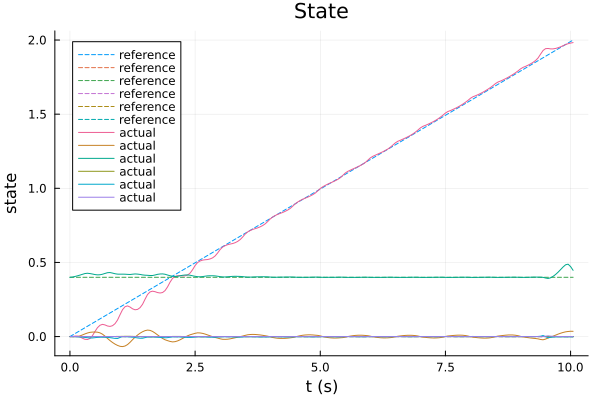

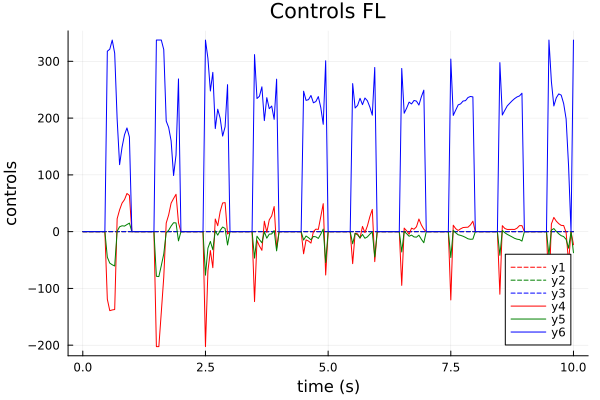

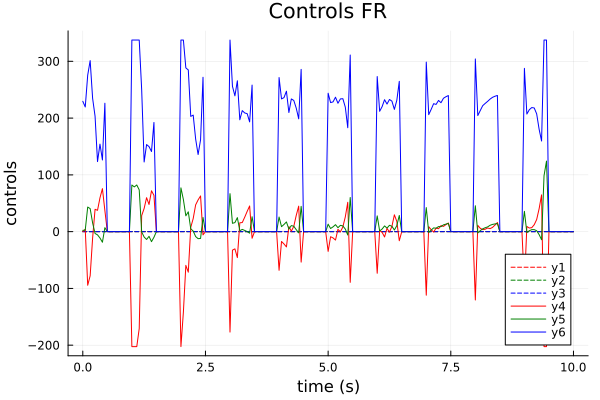

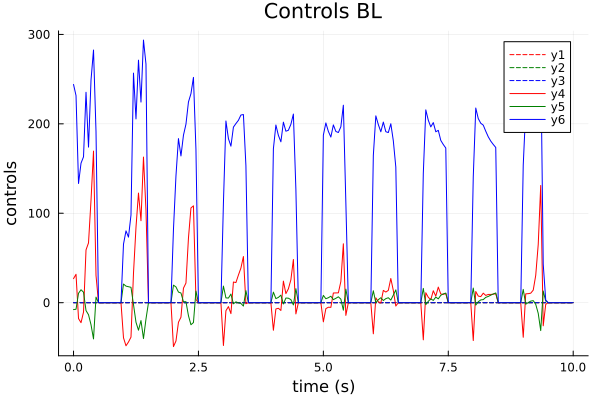

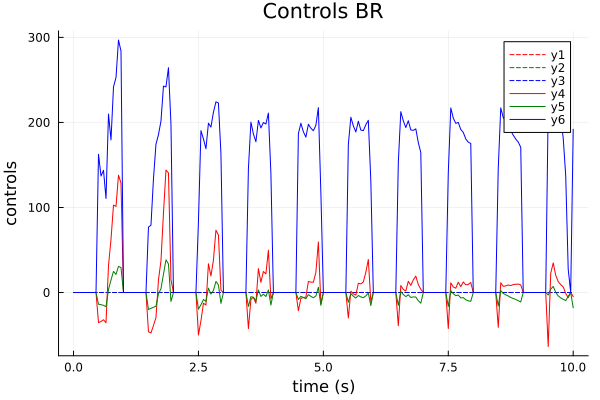

In [353]:
function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end

#model defined here
model = (g = -9.81, m = 43.0, J = diagm([0.41,2.1,2.1]), l = 0.8, w = 0.3, h = 0.4, mu = 0.6)
v = 0.2
dt = 0.05
gait_period = 1
num_gaits = 10
xic = [0,0,model.h,0,0,0,0,0,0,0,0,0]
xg = [v*gait_period*num_gaits,0,model.h,0,0,0,0,0,0,0,0,0]

#construct reference trajectory
Xref, N, fl_s, fr_s, bl_s, br_s, r1, r2, r3, r4 = reference_trajectory(model, xic, xg, dt, gait_period, num_gaits)

Uref = [zeros(12) for i=1:N-1]

# @show r1
# @show r2
# @show r3
# @show r4
# @show N

tf = N * dt 
t_vec = 0:dt:tf 

nx = 12
nu = 12

# LQR tracking cost to be used in ILC 
Q = diagm([100,100,100,100,100,100,1,1,1,1,1,1,0])
R = 0*diagm(ones(nu))
Qf = 10*Q
            
# calculate Jacobians
As = [zeros(nx,nx) for i = 1:N-1]
Bs = [zeros(nx,nu) for i = 1:N-1]
for i = 1:N-1
    As[i] = FD.jacobian(x -> rk4(model, dynamics, x, Uref[i], r1[i], r2[i], r3[i], r4[i], dt), Xref[i])
    Bs[i] = FD.jacobian(u -> rk4(model, dynamics, Xref[i], u, r1[i], r2[i], r3[i], r4[i], dt), Uref[i])
end

# @show As[6]
# @show As[7]
# @show Bs[6]
# @show Bs[7]

real_model = (g = -9.81, m = 50.0, J = diagm([0.5,2.5,2.5]), l = 0.8, w = 0.3, h = 0.4, mu = 0.6)
Xsim = [zeros(13) for i=1:N]
Usim = [zeros(12) for i=1:N-1]
Xsim[1] = Xref[1]

horizon = 20
for j = 1:N-1

    # create variables 
    X = cvx.Variable(nx+1, horizon) #add extra state dimension for gravity
    U = cvx.Variable(nu, horizon-1)

    # cost function (tracking cost on Xref, Uref)
    cost = 0.0
    for k = 1:horizon
        # add stagewise cost 
        if (k+j < N) & (k < horizon)
            cost += 0.5*cvx.quadform(X[:,k] - Xref[k+j],Q) + 0.5*cvx.quadform(U[:,k],R)
        else
            cost += 0.5*cvx.quadform(X[:,k] - Xref[N],Qf)
        end
    end

    # problem instance
    prob = cvx.minimize(cost)

    # initial condition constraint
    prob.constraints += (X[:,1] == Xsim[j])

    # final condition constraint
#     if j+horizon < N
#         prob.constraints += (X[:,horizon] == Xref[j+horizon])
#     else
#         prob.constraints += (X[:,horizon] == Xref[N])        
#     end

    # dynamics constraints
    for k = 1:horizon-1
        if j+k < N-1
            A = As[j+k]
            B = Bs[j+k]
        else
            A = As[N-1]
            B = Bs[N-1]
        end
        prob.constraints += (X[:,k+1] == A*X[:,k] +B*U[:,k])
    end

    #height constraint (no limbo)
#     for k = 1:horizon
#         prob.constraints += (X[3,k] > model.h * 0.8)
#         prob.constraints += (X[3,k] < model.h * 1.2)
#     end

    # gait constraints (only able to use feet when the are on the ground)
    for k = 1:horizon-1
        if k+j < N
            if fl_s[k+j] == 0
                prob.constraints += (U[3,k] == 0)
            else
                prob.constraints += (U[3,k] > 0)  
                prob.constraints += (U[3,k] <= -model.m*model.g*0.8)        
            end
            if fr_s[k+j] == 0
                prob.constraints += (U[6,k] == 0)
            else
                prob.constraints += (U[6,k] > 0)
                prob.constraints += (U[6,k] <= -model.m*model.g*0.8)   
            end
            if bl_s[k+j] == 0
                prob.constraints += (U[9,k] == 0)
            else
                prob.constraints += (U[9,k] > 0) 
                prob.constraints += (U[9,k] <= -model.m*model.g*0.8)  
            end
            if br_s[k+j] == 0
                prob.constraints += (U[12,k] == 0)
            else
                prob.constraints += (U[12,k] > 0) 
                prob.constraints += (U[12,k] <= -model.m*model.g*0.8)  
            end
        else
            if fl_s[N-1] == 0
                prob.constraints += (U[3,k] == 0)
            else
                prob.constraints += (U[3,k] > 0)  
                prob.constraints += (U[3,k] <= -model.m*model.g*0.8)        
            end
            if fr_s[N-1] == 0
                prob.constraints += (U[6,k] == 0)
            else
                prob.constraints += (U[6,k] > 0)
                prob.constraints += (U[6,k] <= -model.m*model.g*0.8)   
            end
            if bl_s[N-1] == 0
                prob.constraints += (U[9,k] == 0)
            else
                prob.constraints += (U[9,k] > 0) 
                prob.constraints += (U[9,k] <= -model.m*model.g*0.8)  
            end
            if br_s[N-1] == 0
                prob.constraints += (U[12,k] == 0)
            else
                prob.constraints += (U[12,k] > 0) 
                prob.constraints += (U[12,k] <= -model.m*model.g*0.8)  
            end
        end
    end

    #friction constraints (friction cone)
    for k = 1:horizon-1
        #front left
        prob.constraints += (U[1,k] <= model.mu * U[3,k])
        prob.constraints += (U[1,k] >= -model.mu * U[3,k])
        prob.constraints += (U[2,k] <= model.mu * U[3,k])
        prob.constraints += (U[2,k] >= -model.mu * U[3,k])
        #front right
        prob.constraints += (U[4,k] <= model.mu * U[6,k])
        prob.constraints += (U[4,k] >= -model.mu * U[6,k])
        prob.constraints += (U[5,k] <= model.mu * U[6,k])
        prob.constraints += (U[5,k] >= -model.mu * U[6,k])
        #back left
        prob.constraints += (U[7,k] <= model.mu * U[9,k])
        prob.constraints += (U[7,k] >= -model.mu * U[9,k])
        prob.constraints += (U[8,k] <= model.mu * U[9,k])
        prob.constraints += (U[8,k] >= -model.mu * U[9,k])
        #back right
        prob.constraints += (U[10,k] <= model.mu * U[12,k])
        prob.constraints += (U[10,k] >= -model.mu * U[12,k])
        prob.constraints += (U[11,k] <= model.mu * U[12,k])
        prob.constraints += (U[11,k] >= -model.mu * U[12,k])
    end

    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true) #solver does the heavy lifting
        
    # get X and U
    X = vec_from_mat(X.value)
    U = vec_from_mat(U.value)
    
    Usim[j] = U[1]
    Xsim[j+1] = X[2]
    @show X[2]
    @show rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt)
    @show (As[j]*Xsim[j] + Bs[j]*Usim[j])
#     Xsim[j+1] = rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt)
end


#simulate to see if our dynamics are right
# Xsim = [zeros(12) for i = 1:N]
# Xsim[1] = Xref[1]

# for i = 1:N-1
#     Xsim[i+1] = rk4(model, dynamics, Xsim[i], U[i], r1[i], r2[i], r3[i], r4[i], dt)
# end

# @show Xsim[1]
# @show U[1]
# @show Xsim[2]
# @show r1[1]
# @show r2[1]
# @show r3[1]
# @show r4[1]
# @show As[1]
# @show Bs[1]
# @show C

#plots
Xm= hcat(Xsim...)
Um = hcat(Usim...)
Xrefm = hcat(Xref...)
Urefm = hcat(Uref...)
r1 = hcat(r1...)
r2 = hcat(r2...)
r3 = hcat(r3...)
r4 = hcat(r4...)

# @show (hcat(r3...) - Xrefm[1:3,:])[1:3,:]

plot(t_vec[1:end-1], Xrefm[1:6,:]', ls = :dash, label = "reference",
xlabel = "t (s)", ylabel = "state", title = "State")
display(plot!(t_vec[1:end-1], Xm[1:6,:]', label = "actual"))
    
plot(t_vec[1:end-2], Urefm[1:3,:]', ls = :dash, lc = [:red :green :blue],
xlabel = "time (s)", ylabel = "controls", title = "Controls FL")
display(plot!(t_vec[1:end-2], Um[1:3,:]', lc = [:red :green :blue]))
    plot(t_vec[1:end-2], Urefm[4:6,:]', ls = :dash, lc = [:red :green :blue],
xlabel = "time (s)", ylabel = "controls", title = "Controls FR")
display(plot!(t_vec[1:end-2], Um[4:6,:]', lc = [:red :green :blue]))
plot(t_vec[1:end-2], Urefm[7:9,:]', ls = :dash, lc = [:red :green :blue],
xlabel = "time (s)", ylabel = "controls", title = "Controls BL")
display(plot!(t_vec[1:end-2], Um[7:9,:]', lc = [:red :green :blue]))
plot(t_vec[1:end-2], Urefm[10:12,:]', ls = :dash, lc = [:red :green :blue],
xlabel = "time (s)", ylabel = "controls", title = "Controls BR")
display(plot!(t_vec[1:end-2], Um[10:12,:]', lc = [:red :green :blue]))